In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from sklearn.metrics import precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import gc
import numpy as np
from torchsummary import summary


# Base functions

## Data loaders

In [ ]:
class DataLoaderWrapCIFAR10:
    def __init__(self, batch = 64):
        transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        ])

        self.train_data = datasets.CIFAR10(
            root="./data",
            train=True,
            transform=transform,
            download=True
        )

        self.test_data = datasets.CIFAR10(
            root="./data",
            train=False,
            transform=transform,
            download=True
        )

        self.train_loader = DataLoader(
            self.train_data,
            batch_size=batch,
            shuffle=True
            )

        self.test_loader = DataLoader(
            self.test_data,
            batch_size=batch,
            shuffle=False
            )

        self.class_names = self.train_data.classes


In [ ]:
class DataLoaderWrapEMNIST:
    def __init__(self, batch = 64):
        transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize((0.5,), (0.5,))
        ])

        self.train_data = datasets.EMNIST(
            root="./data",
            split = 'letters',
            train=True,
            transform=transform,
            download=True
        )

        self.test_data = datasets.EMNIST(
            root="./data",
            split = 'letters',
            train=False,
            transform=transform,
            download=True
        )

        self.train_loader = DataLoader(
            self.train_data,
            batch_size=batch,
            shuffle=True
            )

        self.test_loader = DataLoader(
            self.test_data,
            batch_size=batch,
            shuffle=False
            )

        self.class_names = self.train_data.classes

## Trainer

In [ ]:
class ModelUtils:
    def __init__(self, model, learning_rate=0.001):
        self.model = model

        self.device = torch.device(
            "cuda" if torch.cuda.is_available() else "cpu"
        )

        self.model.to(self.device)

        self.criterion = nn.CrossEntropyLoss()

        self.optimizer = optim.Adam(
            self.model.parameters(),
            lr=learning_rate
        )

    def train(self, train_loader, test_loader, epochs):
        self.model.train()
        self.training_losses = []
        self.validation_losses = []
        training_outputs = []
        validation_outputs = []

        for epoch in range(epochs):
            running_loss = 0.0
            for inputs, labels in train_loader:

                inputs = inputs.to(self.device)
                labels = labels.to(self.device)

                self.optimizer.zero_grad()

                training_outputs = self.model(inputs)

                loss = self.criterion(training_outputs[0], labels)
                loss.backward()
                self.optimizer.step()
                running_loss += loss.item()

            avg_training_loss = running_loss / len(train_loader)
            self.training_losses.append(avg_training_loss)

            val_loss = 0.0

            self.model.eval()
            with torch.no_grad():
                for val_inputs, val_labels in test_loader:
                    val_inputs, val_labels = val_inputs.to(self.device), val_labels.to(self.device)
                    validation_outputs = self.model(val_inputs)
                    val_loss += self.criterion(validation_outputs[0], val_labels).item()

            avg_validation_loss = val_loss / len(test_loader)
            self.validation_losses.append(avg_validation_loss)
            self.model.train()

            print(f"Epoch {epoch + 1}, Training Loss: {avg_training_loss}, Validation Loss: {avg_validation_loss}")

    def evaluate(self, test_loader):
        self.model.eval()
        correct = 0
        total = 0
        all_labels = []
        all_predictions = []
        with torch.no_grad():
            for inputs, labels in test_loader:

                inputs = inputs.to(self.device)
                labels = labels.to(self.device)

                outputs = self.model(inputs)

                _, predicted = torch.max(outputs[0].data, 1)

                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                all_labels.extend(labels.cpu().numpy())
                all_predictions.extend(predicted.cpu().numpy())

        accuracy = 100 * correct / total
        precision = precision_score(all_labels, all_predictions, average='weighted')
        recall = recall_score(all_labels, all_predictions, average='weighted')
        f1 = f1_score(all_labels, all_predictions, average='weighted')

        print(f"Accuracy: {accuracy}%")
        print(f"Precision: {precision}")
        print(f"Recall: {recall}")
        print(f"F1 Score: {f1}")

        plt.plot(range(1, len(self.training_losses) + 1), self.training_losses, label='Training Loss', marker='o')
        plt.plot(range(1, len(self.validation_losses) + 1), self.validation_losses, label='Validation Loss', marker='x')
        plt.title("Training and Validation Loss")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.legend()
        plt.show()

    def predict(self, image):
        self.model.eval()
        image = image.to(self.device)
        with torch.no_grad():
            output = self.model(image.unsqueeze(0))
            _, predicted = torch.max(output[0].data, 1)
        return predicted.item(), output[1:]

    def save_model(self, file_path):
        torch.save(self.model.state_dict(), file_path)
        print(f"Model saved to {file_path}")

    def load_model(self, file_path):
        self.model.load_state_dict(torch.load(file_path))
        self.model.to(self.device)
        print(f"Model loaded from {file_path}")

    def remove_model(self):
        self.model.to('cpu')
        del self.model
        gc.collect()
        torch.cuda.empty_cache()


# AlexNet

In [ ]:
class AlexNet(nn.Module):
    def __init__(self, num_classes):
        super(AlexNet, self).__init__()
        self.conv1 = nn.LazyConv2d(96, kernel_size=11, stride=4, padding=1)
        self.conv2 = nn.LazyConv2d(256, kernel_size=5, padding=2)
        self.conv3 = nn.LazyConv2d(384, kernel_size=3, padding=1)
        self.conv4 = nn.LazyConv2d(384, kernel_size=3, padding=1)
        self.conv5 = nn.LazyConv2d(384, kernel_size=3, padding=1)

        self.fc1 = nn.LazyLinear(4096)
        self.fc2 = nn.LazyLinear(4096)
        self.fc3 = nn.LazyLinear(num_classes)

        self.activation = nn.ReLU()
        self.pool = nn.MaxPool2d(kernel_size=3, stride=2)
        self.dropout = nn.Dropout()


    def forward(self, x):
        x = self.activation(self.conv1(x))
        conv1_output = x
        x = self.pool(x)
        pool1_output = x
        x = self.activation(self.conv2(x))
        conv2_output = x
        x = self.pool(x)
        pool2_output = x

        x = self.activation(self.conv3(x))
        conv3_output = x

        x = self.activation(self.conv4(x))
        conv4_output = x

        x = self.activation(self.conv5(x))
        conv5_output = x
        x = self.pool(x)
        pool3_output = x

        x = torch.flatten(x, 1)

        x = self.dropout(self.activation(self.fc1(x)))
        x = self.dropout(self.activation(self.fc2(x)))
        x = self.fc3(x)
        output = x

        return (output, conv1_output, pool1_output, conv2_output, pool2_output,
                conv3_output, conv4_output, conv5_output, pool3_output)


# Inference

In [ ]:
def visualize(classes, example_image, predicted_label, layers_output, number_of_plots_in_row=6):
    if example_image.ndim == 3:
        example_image = np.transpose(example_image, (1, 2, 0))

    # unnormilize
    example_image = (example_image.squeeze().numpy()) / 2 + 0.5
    # to uint8
    example_image = (example_image * 255).astype('uint8')

    # Create a figure with the appropriate number of subplots
    fig, axs = plt.subplots(len(layers_output) + 1, number_of_plots_in_row, figsize=(2 * number_of_plots_in_row, 4 * len(layers_output)))

    # Display the example image in the center of the first row
    axs[0, number_of_plots_in_row // 2].imshow(example_image)
    if classes is not None:
        axs[0, number_of_plots_in_row // 2].set_title(f"Predicted Label - {predicted_label}: {classes[predicted_label]}")
    else:
        axs[0, number_of_plots_in_row // 2].set_title(f"Predicted Label - {predicted_label}")
    axs[0, number_of_plots_in_row // 2].axis('off')

    # Remove other subplots in the first row
    for i in range(number_of_plots_in_row):
        if i != number_of_plots_in_row // 2:
            fig.delaxes(axs[0, i])

    for i, layer_output in enumerate(layers_output):
        for tensor in layer_output:
            num_of_dim = tensor.shape[0]
            step = (num_of_dim + number_of_plots_in_row - 1) // number_of_plots_in_row
            for j in range(0, num_of_dim):
                ax_index = (i + 1) * number_of_plots_in_row + j // step
                if ax_index < len(axs.flat):
                    ax = axs.flat[ax_index]
                    ax.imshow(tensor[j].cpu().detach().numpy())
                    ax.set_title(f"Output of {i + 1} layer")
                    ax.get_yaxis().set_visible(False)  # Убираем ось Y
                    ax.set_xlabel(f"Layer {i + 1}; Ch {j + 1}")

            # Make remaining subplots empty and without axes
            for k in range(num_of_dim // step + 1, number_of_plots_in_row):
                ax_index = (i + 1) * number_of_plots_in_row + k
                if ax_index < len(axs.flat):
                    ax = axs.flat[ax_index]
                    ax.axis('off')
                    ax.set_visible(False)  # Скрываем ось

    # Remove any unused subplots
    for ax in axs.flat[(len(layers_output) + 1) * number_of_plots_in_row:]:
        fig.delaxes(ax)

    plt.tight_layout()
    plt.show()

## CIFAR10

In [ ]:
data = DataLoaderWrapCIFAR10(batch = 512)
alexnet = ModelUtils(AlexNet(len(data.class_names)), learning_rate=0.001)


In [ ]:
summary(alexnet.model, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 96, 54, 54]          34,944
              ReLU-2           [-1, 96, 54, 54]               0
         MaxPool2d-3           [-1, 96, 26, 26]               0
            Conv2d-4          [-1, 256, 26, 26]         614,656
              ReLU-5          [-1, 256, 26, 26]               0
         MaxPool2d-6          [-1, 256, 12, 12]               0
            Conv2d-7          [-1, 384, 12, 12]         885,120
              ReLU-8          [-1, 384, 12, 12]               0
            Conv2d-9          [-1, 384, 12, 12]       1,327,488
             ReLU-10          [-1, 384, 12, 12]               0
           Conv2d-11          [-1, 384, 12, 12]       1,327,488
             ReLU-12          [-1, 384, 12, 12]               0
        MaxPool2d-13            [-1, 384, 5, 5]               0
           Linear-14                 [-

In [ ]:
epochs=20
alexnet.train(data.train_loader, data.test_loader, epochs=epochs)


Epoch 1, Training Loss: 2.0814392432874564, Validation Loss: 1.6975723385810852
Epoch 2, Training Loss: 1.5491301672799247, Validation Loss: 1.3333143770694733
Epoch 3, Training Loss: 1.2636447293417794, Validation Loss: 1.1967897415161133
Epoch 4, Training Loss: 1.0750557463996264, Validation Loss: 0.996252390742302
Epoch 5, Training Loss: 0.9282938187219658, Validation Loss: 0.9795308500528336
Epoch 6, Training Loss: 0.8352509475484187, Validation Loss: 0.8735333681106567
Epoch 7, Training Loss: 0.7148178085988882, Validation Loss: 0.8437137007713318
Epoch 8, Training Loss: 0.6203075768996258, Validation Loss: 0.8177682340145112
Epoch 9, Training Loss: 0.5508824741962005, Validation Loss: 0.8574113249778748
Epoch 10, Training Loss: 0.4692027882045629, Validation Loss: 0.820717790722847
Epoch 11, Training Loss: 0.40549574123353377, Validation Loss: 0.8737702131271362
Epoch 12, Training Loss: 0.33942221713309384, Validation Loss: 0.8847005575895309
Epoch 13, Training Loss: 0.2976820183

Accuracy: 74.78%
Precision: 0.7473164935612695
Recall: 0.7478
F1 Score: 0.7465464533588966


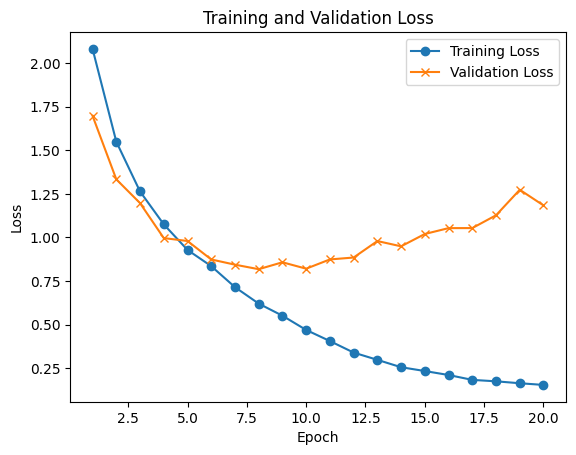

In [ ]:
alexnet.evaluate(data.test_loader)

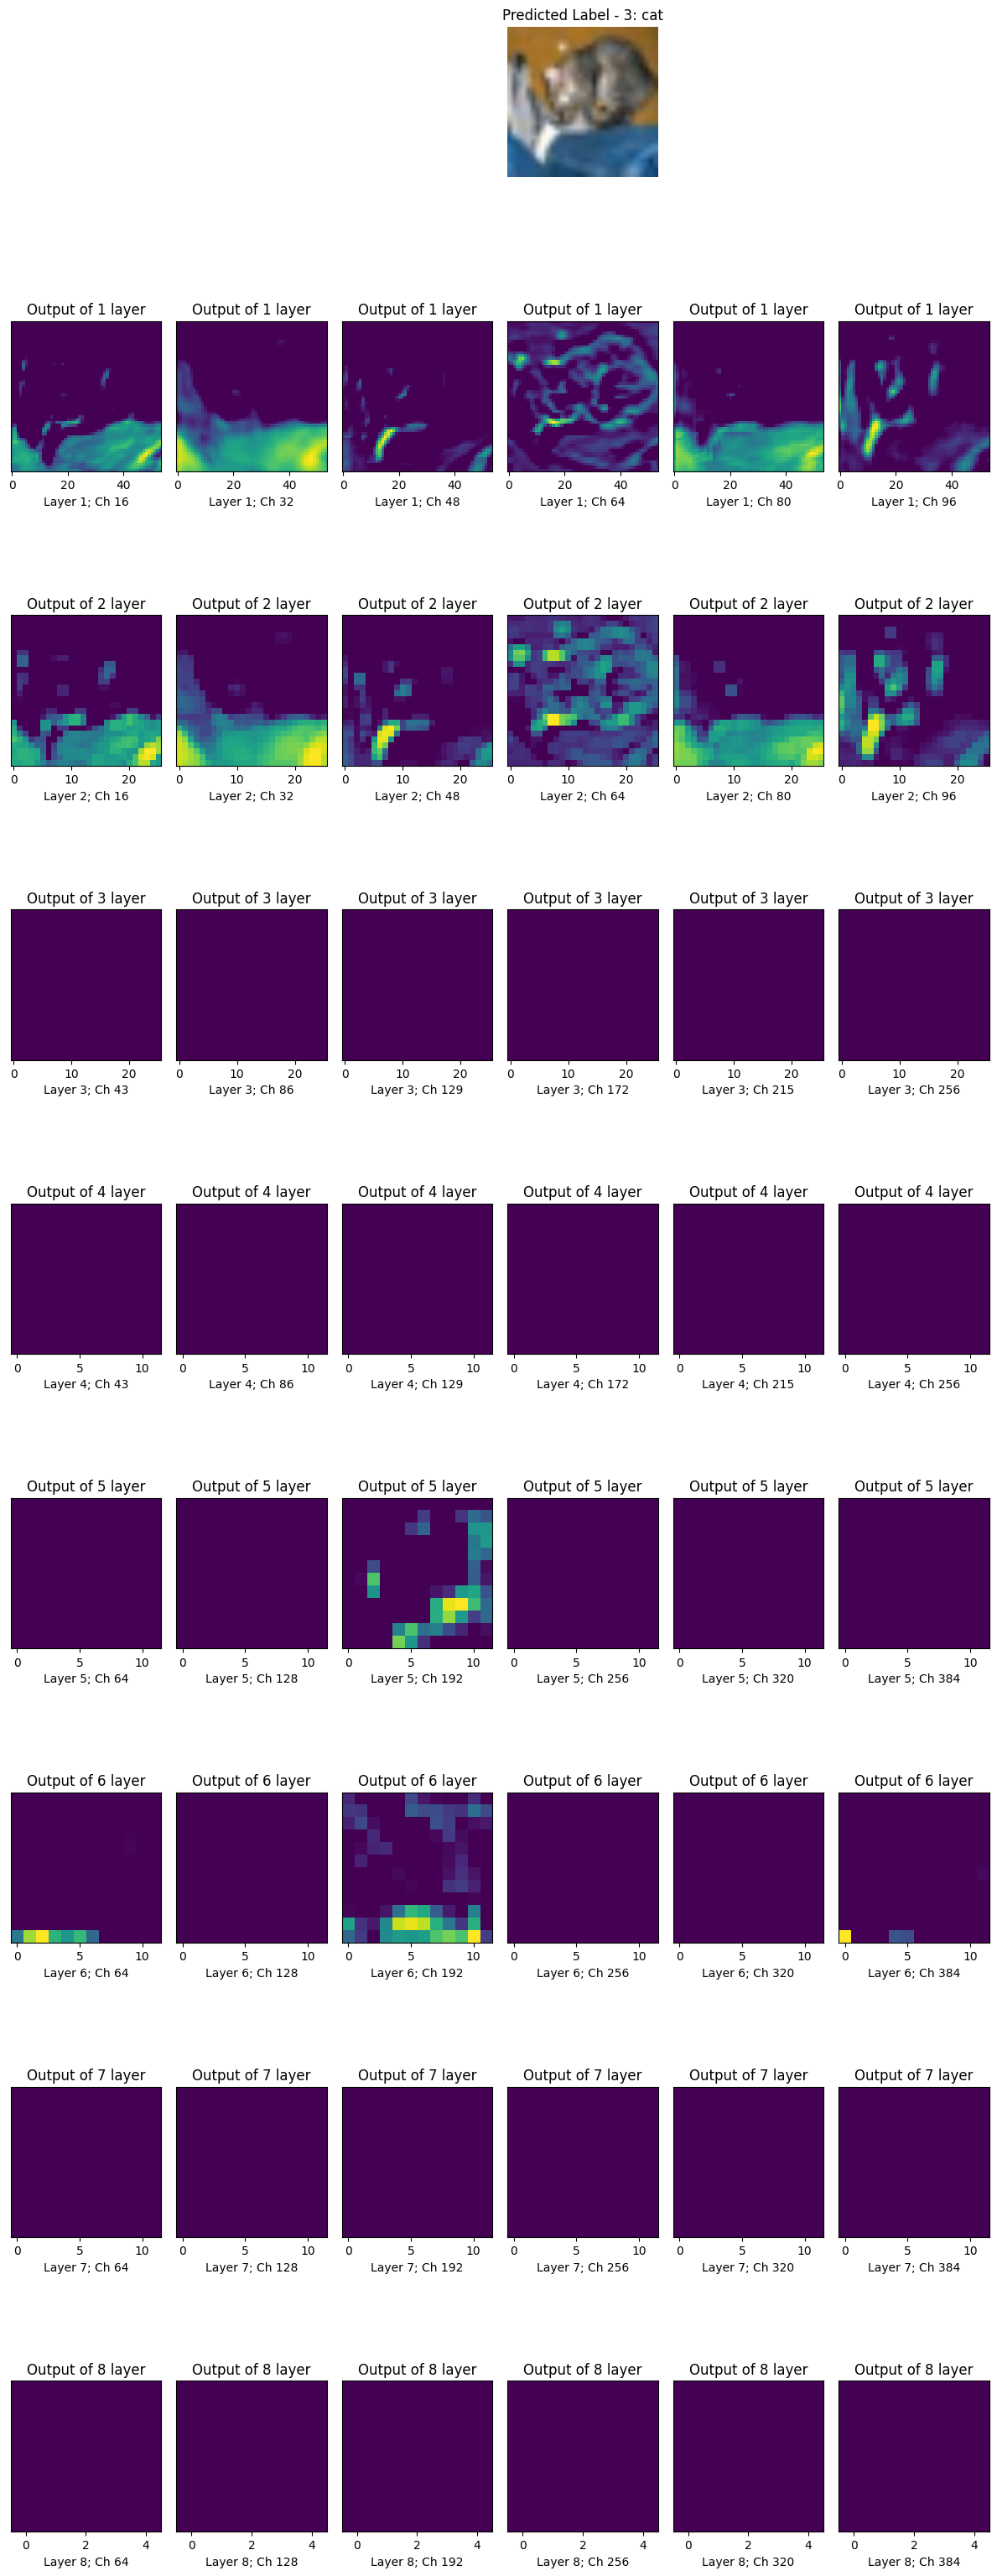

In [ ]:
example_image, _ = next(iter(data.test_loader))
example_image = example_image[0]
predicted_label, layers_output = alexnet.predict(example_image)
visualize(data.class_names, example_image, predicted_label, layers_output, number_of_plots_in_row = 6)

## EMNIST

In [ ]:
data = DataLoaderWrapEMNIST(batch = 512)
alexnet = ModelUtils(AlexNet(len(data.class_names)), learning_rate=0.001)

In [ ]:
summary(alexnet.model, (1, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 96, 54, 54]          11,712
              ReLU-2           [-1, 96, 54, 54]               0
         MaxPool2d-3           [-1, 96, 26, 26]               0
            Conv2d-4          [-1, 256, 26, 26]         614,656
              ReLU-5          [-1, 256, 26, 26]               0
         MaxPool2d-6          [-1, 256, 12, 12]               0
            Conv2d-7          [-1, 384, 12, 12]         885,120
              ReLU-8          [-1, 384, 12, 12]               0
            Conv2d-9          [-1, 384, 12, 12]       1,327,488
             ReLU-10          [-1, 384, 12, 12]               0
           Conv2d-11          [-1, 384, 12, 12]       1,327,488
             ReLU-12          [-1, 384, 12, 12]               0
        MaxPool2d-13            [-1, 384, 5, 5]               0
           Linear-14                 [-

In [ ]:
epochs=20
alexnet.train(data.train_loader, data.test_loader, epochs=epochs)

Epoch 1, Training Loss: 0.9995502757488705, Validation Loss: 0.2606431688295632
Epoch 2, Training Loss: 0.24604174561920714, Validation Loss: 0.19412786586255562
Epoch 3, Training Loss: 0.1954235436669627, Validation Loss: 0.17817662915260327
Epoch 4, Training Loss: 0.17443353780468956, Validation Loss: 0.16675362545179157
Epoch 5, Training Loss: 0.15685497022798803, Validation Loss: 0.1666557673910042
Epoch 6, Training Loss: 0.1478164117233675, Validation Loss: 0.15913735225614978
Epoch 7, Training Loss: 0.14112648111386378, Validation Loss: 0.16334000845417018
Epoch 8, Training Loss: 0.1314970116268416, Validation Loss: 0.15600874770160128
Epoch 9, Training Loss: 0.1265469222619641, Validation Loss: 0.16021730171561968
Epoch 10, Training Loss: 0.11807812860266106, Validation Loss: 0.16296722035764194
Epoch 11, Training Loss: 0.11615819025967943, Validation Loss: 0.15905816412371834
Epoch 12, Training Loss: 0.11470528221765502, Validation Loss: 0.1654152092410297
Epoch 13, Training Lo

Accuracy: 94.67307692307692%
Precision: 0.9469366461171533
Recall: 0.9467307692307693
F1 Score: 0.946744445329778


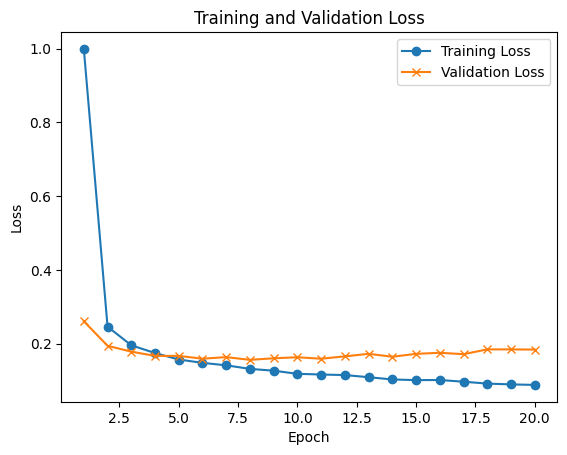

In [ ]:
alexnet.evaluate(data.test_loader)

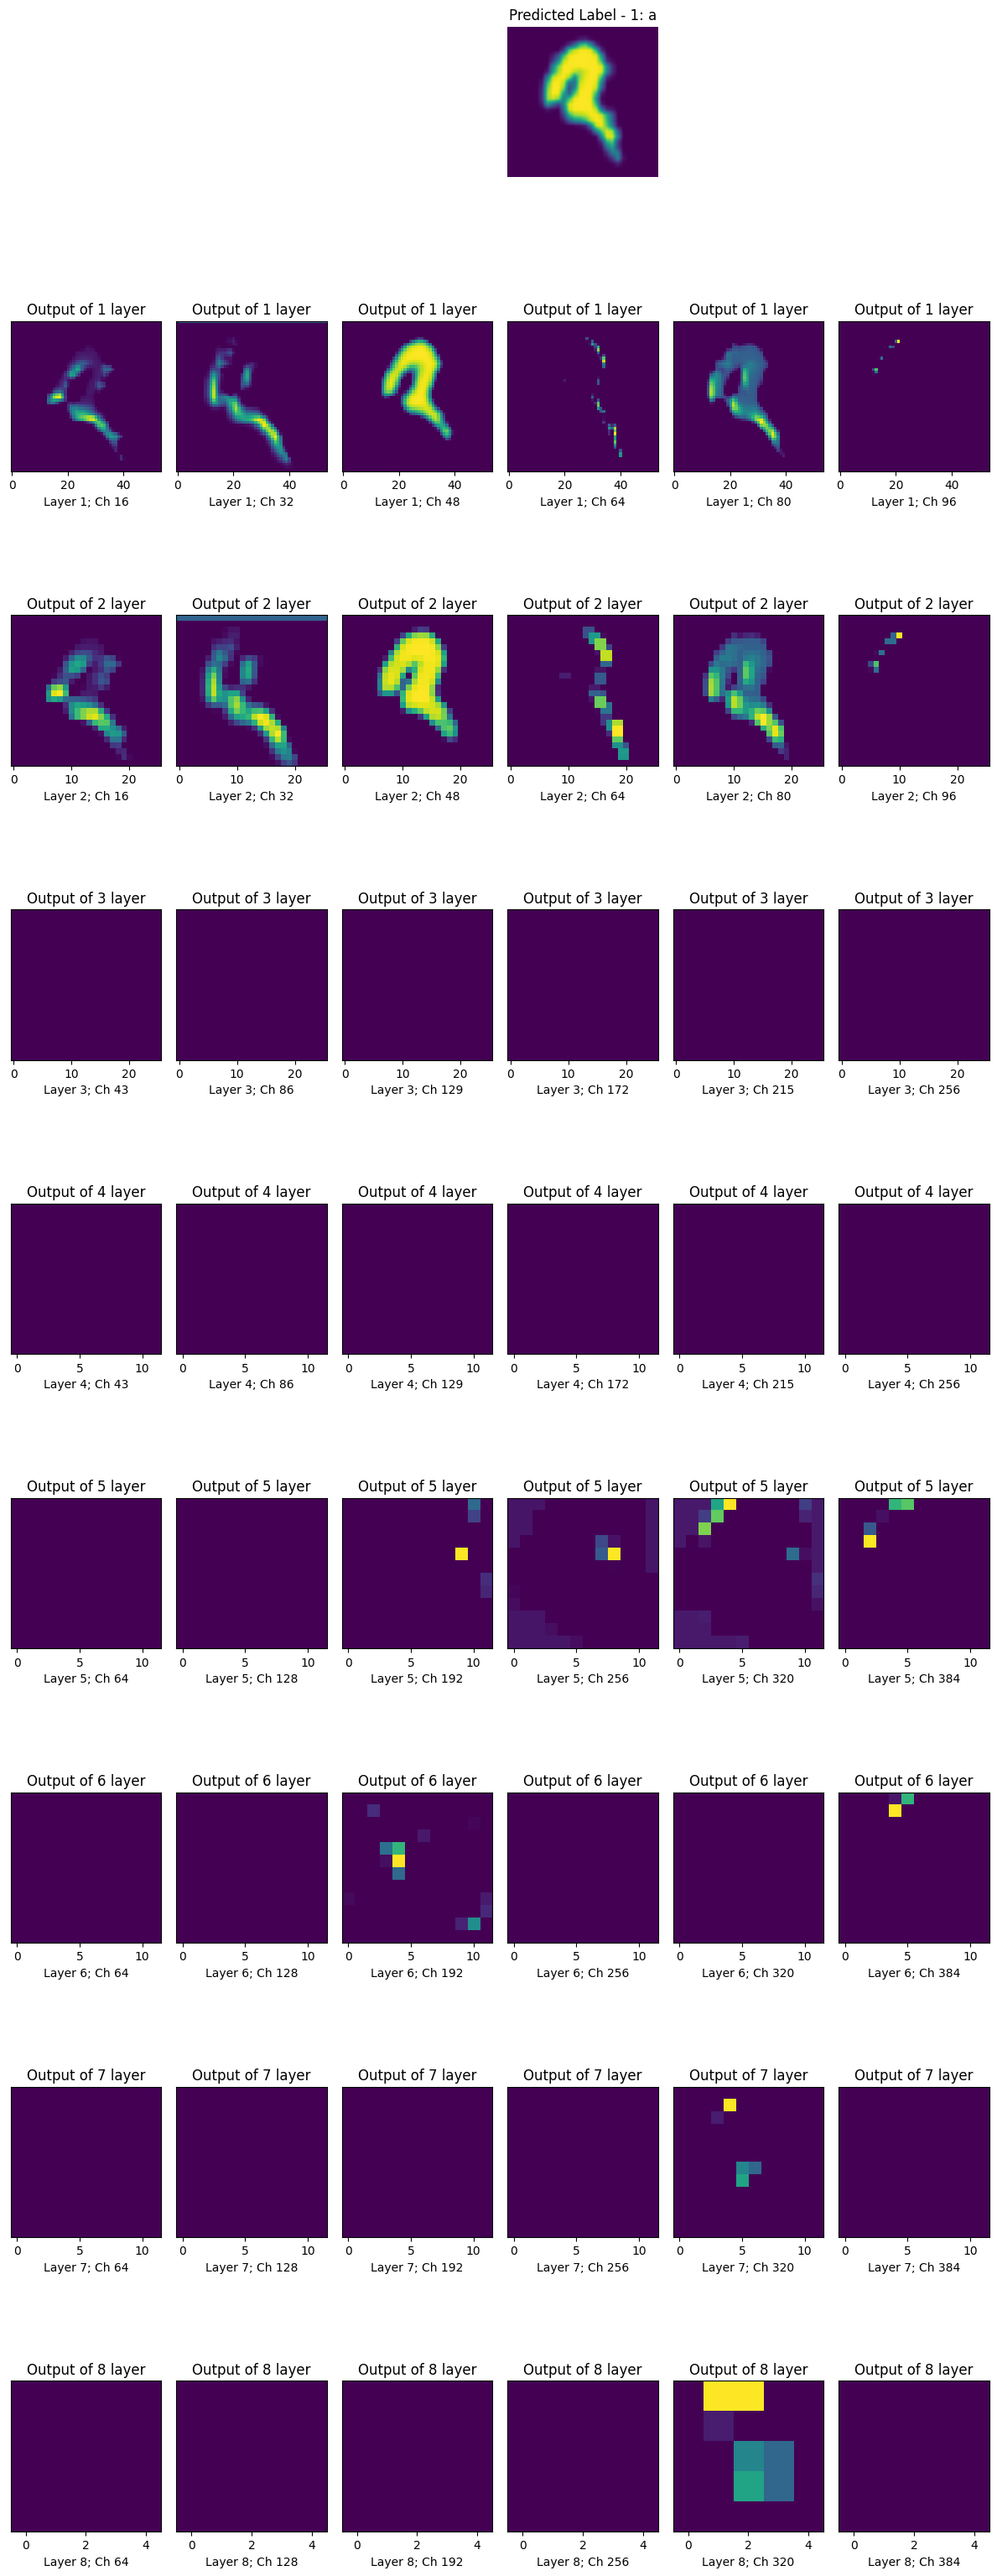

In [ ]:
example_image, _ = next(iter(data.test_loader))
example_image = example_image[0]
predicted_label, layers_output = alexnet.predict(example_image)
visualize(data.class_names, example_image, predicted_label, layers_output, number_of_plots_in_row = 6)

# Exercises

## Following up on the discussion above, analyze the computational properties of AlexNet.

### Compute the memory footprint for convolutions and fully connected layers, respectively. Which one dominates?

num_of_param_conv = sum from 0 to num_of_layers (input_d * output_d * k_w * k_h + output_d)
num_of_param_fc = sum from 0 to num_of_layers (input_size * output_size + output_size)

In [ ]:
num_of_param_conv = 3*96*11*11+96+96*256*5*5+256+256*384*3*3+384+384*384*3*3+384+384*256*3*3+256
num_of_param_fc = 80*80*4096+4096+4096*4096+4096+4096*10+10

print(f"Conv: {num_of_param_conv}")
print(f"FC: {num_of_param_fc}")


Conv: 3747200
FC: 43040778


Fully connected layers dominates

### Calculate the computational cost for the convolutions and the fully connected layers.

cost_of_conv = sum from 0 to num_of_layers (input_d * output_d * k_w * k_h * output_h * output_w)
cost_of_param_fc = sum from 0 to num_of_layers (input_size * output_size + output_size)

In [ ]:
cost_of_conv = 3*96*11*11*54*54+96*256*5*5*26*26+256*384*3*3*12*12+384*384*3*3*12*12+384*256*3*3*12*12
cost_of_param_fc = 80*80*4096+4096+4096*4096+4096+4096*10+10

print(f"Conv: {cost_of_conv}")
print(f"FC: {cost_of_param_fc}")


Conv: 962858112
FC: 43040778


### How does the memory (read and write bandwidth, latency, size) affect computation? Is there any difference in its effects for training and inference?

Memory characteristics such as read and write bandwidth, latency, and size significantly affect computing in training and inference neural networks. These factors can affect the overall performance, efficiency, and speed of computing. Here's how these aspects of memory affect computing and the possible differences between learning and inference.:

Read and write bandwidth:

Impact on computing: High throughput allows faster data movement between memory and CPU. Fast access to data reduces training time.
Training and inference: Both processes benefit from high throughput, as both depend on the speed of data delivery.

Delay:

Impact on computing: Lower latency speeds up data access. Low latency = fast data access
Learning and Inference: Learning requires fast access to data to update weights and gradients, and inference requires fast real—time responses.

Memory size:

Impact on the calculation: The size of the memory determines how much data can be stored. More memory = more data => less need to download => faster learning
Training and inference: Both processes will benefit

Differences between learning and inference:
In both cases, the more memory, the better. Bandwidth is more important in training due to frequent updates of weights and gradients, while latency is more important in inference to improve real-time performance.

## You are a chip designer and need to trade off computation and memory bandwidth. For example, a faster chip requires more power and possibly a larger chip area. More memory bandwidth requires more pins and control logic, thus also more area. How do you optimize?

It's a difficult question. It all depends on the type of data used in the neural network, its size, and the optimizations applied. It is important to take into account the availability of materials, the availability of documentation for developers and their experience working with the chip.
In the real world, I would take an OrangePi with a TPU.

## Why do engineers no longer report performance benchmarks on AlexNet?

The model was released more than 12 years ago and due to the abundance of architectures on the market, it can no longer compete, for example, with Reset and transformers.

## Try increasing the number of epochs when training AlexNet. Compared with LeNet, how do the results differ? Why?

At about the 50th or 60th epoch, retraining in MNIST will begin, based on the experience of previous DZ

## Can you make AlexNet overfit? Which feature do you need to remove or change to break training?

Yes, you can reduce the size of the training sample, increase the number of epochs, and remove dropouts.

## 5 - 7

AlexNet may be too complex for the Fashion-MNIST dataset, in particular due to the low resolution of the initial images.

Try simplifying the model to make the training faster, while ensuring that the accuracy does not drop significantly.

Design a better model that works directly on 28x28 images.

Modify the batch size, and observe the changes in throughput (images/s), accuracy, and GPU memory.

Apply dropout and ReLU to LeNet-5. Does it improve? Can you improve things further by preprocessing to take advantage of the invariances inherent in the images?

In [ ]:
class DataLoaderWrapFMINIST:
    def __init__(self, batch = 64):
        transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.5, ), (0.5, ))
        ])

        self.train_data = datasets.FashionMNIST(
            root="./data",
            train=True,
            transform=transform,
            download=True
        )

        self.test_data = datasets.FashionMNIST(
            root="./data",
            train=False,
            transform=transform,
            download=True
        )

        self.train_loader = DataLoader(
            self.train_data,
            batch_size=batch,
            shuffle=True
            )

        self.test_loader = DataLoader(
            self.test_data,
            batch_size=batch,
            shuffle=False
            )

        self.class_names = self.train_data.classes


In [ ]:
class FastAlexNet(nn.Module):
    def __init__(self, num_classes):
        super(FastAlexNet, self).__init__()
        self.conv1 = nn.LazyConv2d(256, kernel_size=3, padding=1)
        self.conv2 = nn.LazyConv2d(256, kernel_size=3, padding=1)
        self.conv3 = nn.LazyConv2d(256, kernel_size=3, padding=1)
        self.conv4 = nn.LazyConv2d(512, kernel_size=3, padding=1)
        self.conv5 = nn.LazyConv2d(512, kernel_size=3, padding=1)
        self.conv6 = nn.LazyConv2d(256, kernel_size=3, padding=1)

        self.fc1 = nn.LazyLinear(1024)
        self.fc2 = nn.LazyLinear(num_classes)

        self.activation = nn.ReLU()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout = nn.Dropout()


    def forward(self, x):
        x = self.activation(self.conv1(x))
        conv1_output = x
        x = self.activation(self.conv2(x))
        conv2_output = x
        x = self.activation(self.conv3(x))
        conv3_output = x

        x = self.pool(x)
        pool1_output = x

        x = self.activation(self.conv4(x))
        conv4_output = x
        x = self.activation(self.conv5(x))
        conv5_output = x
        x = self.activation(self.conv6(x))
        conv6_output = x

        x = self.pool(x)
        pool2_output = x

        x = torch.flatten(x, 1)

        x = self.dropout(self.activation(self.fc1(x)))
        x = self.fc2(x)
        output = x

        return (output, conv1_output, conv2_output, conv3_output, pool1_output,
                conv4_output, conv5_output, conv6_output, pool2_output)


In [ ]:
data = DataLoaderWrapFMINIST(batch = 512)
alexnet = ModelUtils(FastAlexNet(len(data.class_names)), learning_rate=0.001)

In [ ]:
summary(alexnet.model, (1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 256, 28, 28]           2,560
              ReLU-2          [-1, 256, 28, 28]               0
            Conv2d-3          [-1, 256, 28, 28]         590,080
              ReLU-4          [-1, 256, 28, 28]               0
            Conv2d-5          [-1, 256, 28, 28]         590,080
              ReLU-6          [-1, 256, 28, 28]               0
         MaxPool2d-7          [-1, 256, 14, 14]               0
            Conv2d-8          [-1, 512, 14, 14]       1,180,160
              ReLU-9          [-1, 512, 14, 14]               0
           Conv2d-10          [-1, 512, 14, 14]       2,359,808
             ReLU-11          [-1, 512, 14, 14]               0
           Conv2d-12          [-1, 256, 14, 14]       1,179,904
             ReLU-13          [-1, 256, 14, 14]               0
        MaxPool2d-14            [-1, 25

In [ ]:
epochs=20
alexnet.train(data.train_loader, data.test_loader, epochs=epochs)

Epoch 1, Training Loss: 0.8953097790984784, Validation Loss: 0.4476433053612709
Epoch 2, Training Loss: 0.3739763930187387, Validation Loss: 0.33438779413700104
Epoch 3, Training Loss: 0.29608651995658875, Validation Loss: 0.2935464769601822
Epoch 4, Training Loss: 0.2580965617198055, Validation Loss: 0.2719228878617287
Epoch 5, Training Loss: 0.23424574341309273, Validation Loss: 0.2474404864013195
Epoch 6, Training Loss: 0.20886151871438755, Validation Loss: 0.2238713853061199
Epoch 7, Training Loss: 0.1912672818969872, Validation Loss: 0.22492191419005395
Epoch 8, Training Loss: 0.17370870557882018, Validation Loss: 0.21462486684322357
Epoch 9, Training Loss: 0.15867992414761398, Validation Loss: 0.22435517385601997
Epoch 10, Training Loss: 0.14157973068876792, Validation Loss: 0.22049082592129707
Epoch 11, Training Loss: 0.13028953464354498, Validation Loss: 0.21278628185391427
Epoch 12, Training Loss: 0.11824638832171085, Validation Loss: 0.21743513271212578
Epoch 13, Training Los

Accuracy: 92.89%
Precision: 0.929219408338277
Recall: 0.9289
F1 Score: 0.9289307950408491


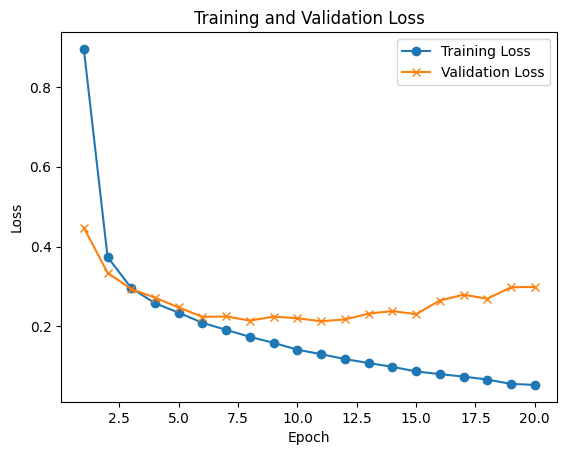

In [ ]:
alexnet.evaluate(data.test_loader)

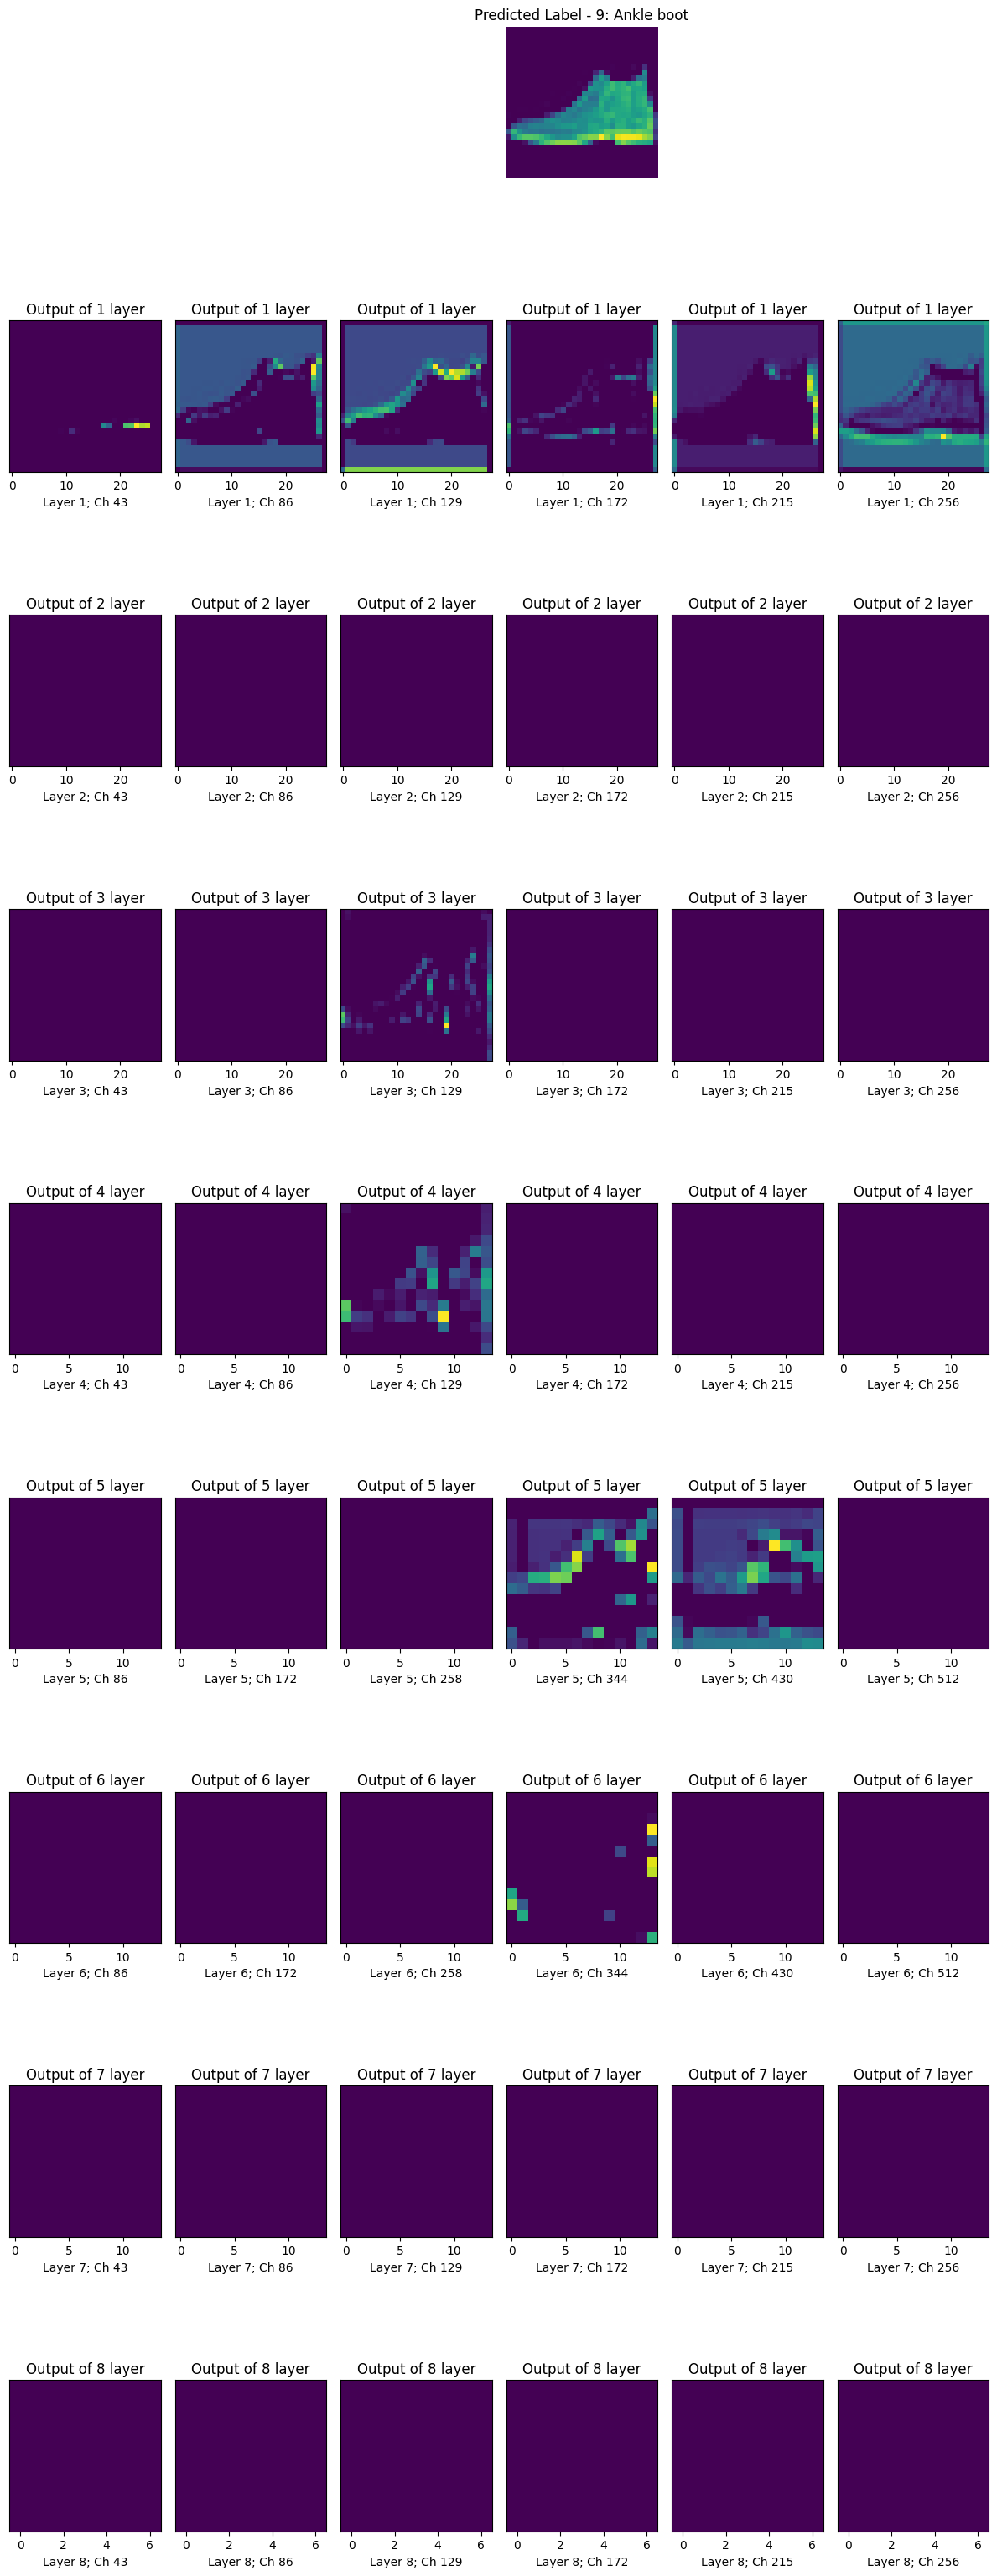

In [ ]:
example_image, _ = next(iter(data.test_loader))
example_image = example_image[0]
predicted_label, layers_output = alexnet.predict(example_image)
visualize(data.class_names, example_image, predicted_label, layers_output, number_of_plots_in_row = 6)